In [1]:
import gzip
from collections import defaultdict

## data loading

In [2]:
def readGz(f):
  for l in gzip.open(f):
    yield eval(l)

allHelpful = []
userHelpful = defaultdict(list)
itemReview = defaultdict(list) # new

for l in readGz("train.json.gz"):
  user,item = l['reviewerID'],l['itemID']
  allHelpful.append(l['helpful'])
  userHelpful[user].append(l['helpful'])
  itemReview[item].append(l)
    
for l in readGz("test_Helpful.json.gz"):
  user,item = l['reviewerID'],l['itemID']
  userHelpful[user].append(l['helpful'])
  itemReview[item].append(l)
    
averageRate = sum([x['nHelpful'] for x in allHelpful]) * 1.0 / sum([x['outOf'] for x in allHelpful])
userRate = {}
userReviewCount = {}
userReviewCount1 = {}
userTotalOutOf = {}
userAvgOutOf = {}
userAvgOutOf1 = {} 
for u in userHelpful:
  userReviewCount[u] = len(userHelpful[u])
  userReviewCount1[u] = len([1 for x in userHelpful[u] if x['outOf'] > 0])
  userTotalOutOf[u] = sum([x['outOf'] for x in userHelpful[u]])
  userTotalHelpful = sum([x.get('nHelpful',0) for x in userHelpful[u]])
  if userTotalOutOf[u] > 0 and userReviewCount[u] > 10:
    userRate[u] = userTotalHelpful * 1.0 / userTotalOutOf[u]
  else:
    userRate[u] = averageRate
  userAvgOutOf[u] = userTotalOutOf[u] / userReviewCount[u]
  userAvgOutOf1[u] = userTotalOutOf[u] / userReviewCount1[u] if userReviewCount1[u]>0 else 0

itemRate = {}
itemReviewCount = {}
itemReviewCount1 = {}
itemTotalOutOf = {}
itemAvgOutOf = {}
itemAvgRating = {}
itemAvgReviewLength = {}
itemReviewLengthMin = {}
itemReviewLengthRange = {}
itemAvgOutOf1 = {}

itemReviewTimeFirst = {}
itemReviewTimeLast = {}
itemReviewTimeSpan = {}
for i in itemReview:
  itemReviewCount[i] = len(itemReview[i])
  itemReviewCount1[i] = len([1 for x in itemReview[i] if x['helpful']['outOf'] > 0])
    
  itemTotalOutOf[i] = sum([x['helpful']['outOf'] for x in itemReview[i]])
  itemTotalHelpful = sum([x['helpful'].get('nHelpful',0) for x in itemReview[i]])
  if itemTotalOutOf[i] > 0 and itemReviewCount[i] > 20:
    itemRate[i] = itemTotalHelpful * 1.0 / itemTotalOutOf[i]
  else:
    itemRate[i] = averageRate
  itemAvgOutOf[i] = itemTotalOutOf[i] / itemReviewCount[i]
  itemAvgRating[i] = sum([x['rating'] for x in itemReview[i]]) / itemReviewCount[i]
  itemAvgReviewLength[i] = sum([len(x['reviewText']) for x in itemReview[i]]) / itemReviewCount[i]
  itemReviewLengthMin[i] = min(len(x['reviewText']) for x in itemReview[i])
  itemReviewLengthRange[i] = max(len(x['reviewText']) for x in itemReview[i]) - itemReviewLengthMin[i]

  itemAvgOutOf1[i] = itemTotalOutOf[i] / itemReviewCount1[i] if itemReviewCount1[i] > 0 else 0
  
  itemReviewTimeFirst[i] = min(x['unixReviewTime'] for x in itemReview[i])
  itemReviewTimeLast[i] = max(x['unixReviewTime'] for x in itemReview[i])
  itemReviewTimeSpan[i] = itemReviewTimeLast[i] - itemReviewTimeFirst[i]

### load as dataframe

In [3]:
import pandas as pd
from collections import defaultdict

def readGz(f):
  for l in gzip.open(f):
    yield eval(l)

def parse(path):
  g = gzip.open(path, 'rb')
  for l in g:
    yield eval(l)

def getDF(path):
  i = 0
  df = {}
  for d in parse(path):
    df[i] = d
    i += 1
  return pd.DataFrame.from_dict(df, orient='index')

df = getDF('train.json.gz')
test_df = getDF('test_Helpful.json.gz')

### data preprocessing ###

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

print(df.shape, test_df.shape)

(200000, 12) (14000, 12)


In [6]:
for dfx in [df, test_df]:
    dfx['outOf'] = dfx.apply(lambda row: row['helpful']['outOf'], axis=1)

    dfx['userRate'] = dfx.apply(lambda row: userRate.get(row['reviewerID'], averageRate), axis=1)
    dfx['itemRate'] = dfx.apply(lambda row: itemRate.get(row['itemID'], averageRate) , axis=1)

    dfx['itemReviewCount'] = dfx.apply(lambda row: itemReviewCount[row['itemID']], axis=1)
    dfx['itemReviewCount1'] = dfx.apply(lambda row: itemReviewCount1[row['itemID']], axis=1)
    dfx['userReviewCount'] = dfx.apply(lambda row: userReviewCount[row['reviewerID']], axis=1)
    dfx['userReviewCount1'] = dfx.apply(lambda row: userReviewCount1[row['reviewerID']], axis=1)

    dfx['userAvgOutOf'] = dfx.apply(lambda row: userAvgOutOf.get(row['reviewerID']) , axis=1)
    dfx['itemAvgOutOf'] = dfx.apply(lambda row: itemAvgOutOf.get(row['itemID']) , axis=1)

    # redundant can be derived from Avg * ReviewCount
    dfx['userTotalOutOf'] = dfx.apply(lambda row: userTotalOutOf.get(row['reviewerID']) , axis=1)
    dfx['itemTotalOutOf'] = dfx.apply(lambda row: itemTotalOutOf.get(row['itemID']) , axis=1)

    dfx['userAvgOutOf1'] = dfx.apply(lambda row: userAvgOutOf1.get(row['reviewerID']) , axis=1)
    dfx['itemAvgOutOf1'] = dfx.apply(lambda row: itemAvgOutOf1.get(row['itemID']) , axis=1)

    dfx['userOutOfRatio'] = dfx.apply(lambda row: row['outOf']/row['userAvgOutOf'] if row['userAvgOutOf'] != 0 else 0, axis=1)
    dfx['itemOutOfRatio'] = dfx.apply(lambda row: row['outOf']/row['itemAvgOutOf'] if row['itemAvgOutOf'] != 0 else 0 , axis=1)
    dfx['userOutOfRatio1'] = dfx.apply(lambda row: row['outOf']/row['userAvgOutOf1'] if row['userAvgOutOf1'] != 0 else 0, axis=1)
    dfx['itemOutOfRatio1'] = dfx.apply(lambda row: row['outOf']/row['itemAvgOutOf1'] if row['itemAvgOutOf1'] != 0 else 0 , axis=1)

    #dfx['itemAvgRating'] = dfx.apply(lambda row: itemAvgRating.get(row['itemID']) , axis=1)
    #dfx['itemRatingDev'] = dfx.apply(lambda row: row['rating']-row['itemAvgRating'] , axis=1)
    dfx['itemAvgRating'] = dfx['rating'].groupby(dfx['itemID']).transform('mean')
    dfx['itemRatingDev'] = dfx['rating'] - dfx['itemAvgRating']

    dfx['reviewLength'] = dfx.apply(lambda row: len(row['reviewText']), axis=1)
    dfx['itemAvgReviewLengthRatio'] = dfx.apply(lambda row: len(row['reviewText']) / itemAvgReviewLength.get(row['itemID']) , axis=1)
    dfx['itemReviewLengthRatio'] = dfx.apply(lambda row: len(row['reviewText']) - itemReviewLengthMin[row['itemID']] / itemReviewLengthRange[row['itemID']] if itemReviewLengthRange[row['itemID']] > 0 else 1, axis=1)

    dfx['itemReviewTimePast'] = dfx.apply(lambda row: row['unixReviewTime']-itemReviewTimeFirst[row['itemID']] , axis=1)
    dfx['itemReviewTimeSpan'] = dfx.apply(lambda row: itemReviewTimeLast[row['itemID']] - itemReviewTimeFirst[row['itemID']], axis=1)
    dfx['itemReviewTimeRatio'] = dfx.apply(lambda row: row['itemReviewTimePast']/itemReviewTimeSpan[row['itemID']] if itemReviewTimeSpan[row['itemID']] > 0 else 0 , axis=1)

    dfx['summaryLength'] = dfx.apply(lambda row: len(row['summary']), axis=1)

df['nHelpful'] = df.apply(lambda row: row['helpful']['nHelpful'], axis=1)
df['helpfulRate'] = df['nHelpful'] / df['outOf']


## investigate data ##

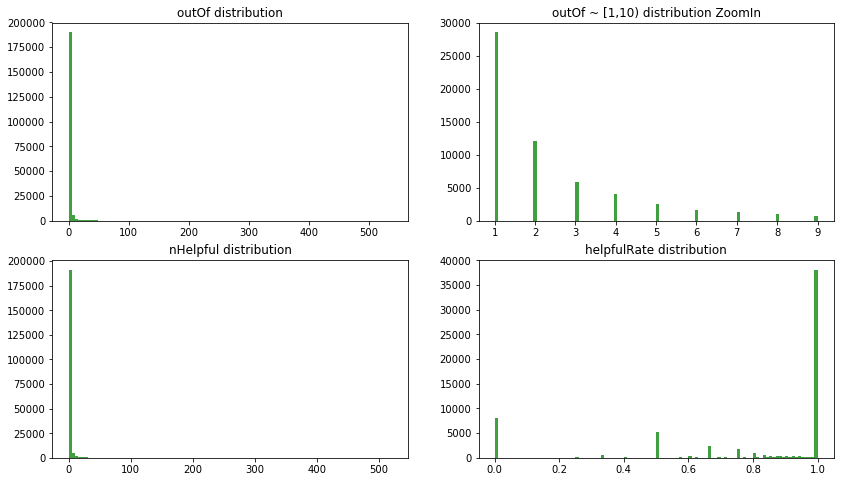

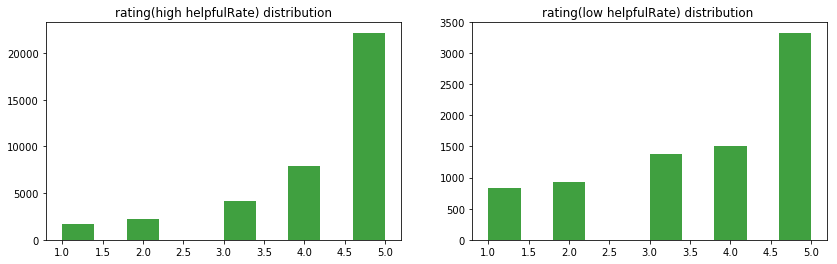

In [46]:
# check distribution of several features
plt.figure(figsize=(14,8))

plt.subplot(2,2,1)
plt.title('outOf distribution')
plt.hist(df['outOf'], 100, histtype='bar', facecolor='green', alpha=0.75)

plt.subplot(2,2,2)
plt.title('outOf ~ [1,10) distribution ZoomIn')
plt.hist(df[(df['outOf']>0)&(df['outOf']<10)]['outOf'], 100, histtype='bar', facecolor='green', alpha=0.75)

plt.subplot(2,2,3)
plt.title('nHelpful distribution')
plt.hist(df['nHelpful'], 100, histtype='bar', facecolor='green', alpha=0.75)

plt.subplot(2,2,4)
plt.title('helpfulRate distribution')
plt.hist(df[np.isfinite(df['helpfulRate'])]['helpfulRate'], 100, histtype='bar', facecolor='green', alpha=0.75)

plt.show()

plt.figure(figsize=(14,4))

plt.subplot(1,2,1)
plt.title('rating(high helpfulRate) distribution')
plt.hist(df[df['helpfulRate']>0.999]['rating'], 10, histtype='bar', facecolor='green', alpha=0.75)
plt.subplot(1,2,2)
plt.title('rating(low helpfulRate) distribution ')
plt.hist(df[df['helpfulRate']<0.001]['rating'], 10, histtype='bar', facecolor='green', alpha=0.75)
plt.show()

C:\Users\wenyan\Anaconda3\lib\site-packages\ipykernel\__main__.py:26: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Users\wenyan\Anaconda3\lib\site-packages\ipykernel\__main__.py:27: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


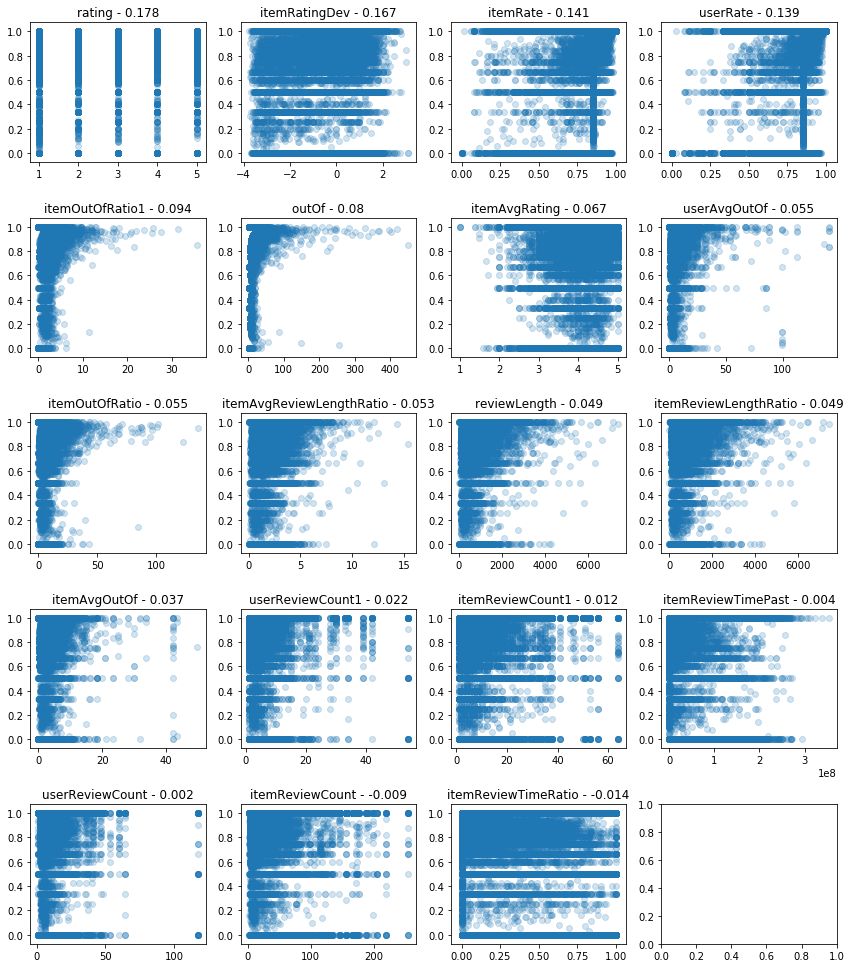

['rating', 'itemRatingDev', 'itemRate', 'userRate', 'itemOutOfRatio1', 'outOf', 'itemAvgRating', 'userAvgOutOf', 'itemOutOfRatio', 'itemAvgReviewLengthRatio', 'reviewLength', 'itemReviewLengthRatio', 'itemAvgOutOf', 'userReviewCount1', 'itemReviewCount1', 'itemReviewTimePast', 'userReviewCount', 'itemReviewCount', 'itemReviewTimeRatio']


In [51]:
# scatter plot of features vs helpfulness
df_valid = df[(df['outOf'] > 0 ) \
              & (df['outOf'] < 500) \
              & (df['reviewLength'] < 7500) \
              #& (df['itemAvgOutOf'] < 20) \
              #& (df['userAvgOutOf'] < 70) \
              #& (df['userReviewCount'] < 75) \
              #& (df['itemAvgReviewLengthRatio'] < 10) \
              #& (df['itemReviewLengthRatio'] < 10000) \
              #& (df['itemTotalOutOf'] < 200) \
             ]

all_features = ['userRate', 'itemRate', 'outOf',  \
                'reviewLength', 'itemReviewLengthRatio', 'itemAvgReviewLengthRatio', \
                'itemAvgOutOf', 'userAvgOutOf', \
                'itemReviewCount', 'itemReviewCount1', 'userReviewCount', 'userReviewCount1', \
                'itemOutOfRatio', 'itemOutOfRatio1', \
                'itemAvgRating', 'itemRatingDev', 'itemReviewTimePast',\
                'itemReviewTimeRatio', 'rating' \
                ]
corrs = {}
for feature in all_features:
    df1 = df_valid[np.isfinite(df_valid[feature])]
    corrs[feature] = df1[feature].corr(df1['helpfulRate'])

fig, ax = plt.subplots(5, 4)
fig.subplots_adjust(left=0.1, right=0.9,
                    bottom=0.1, top=0.9,
                    hspace=0.4, wspace=0.2)
fig.set_size_inches(14,16)
sorted_features = sorted(all_features, key=lambda x: corrs[x], reverse=True)
for i,feature in enumerate(sorted_features):
    df1 = df_valid[np.isfinite(df_valid[feature])]
    corr = corrs[feature]
    x,y = i/4, i%4
    ax[x,y].set_title('{} - {}'.format(feature,round(corr,3)))
    ax[x,y].scatter(df1[feature], df1['helpfulRate'], alpha=0.2)
plt.show()
print(sorted_features)

## feature selection ##
Basically, I started trying with most correlated features, and used selected features for model training and testing. Then turned back to crawling more on features and tuning more on models. There were several iterations on going forth and back between feature selection and model tuning.

In [ ]:
# try different features
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error,mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.pipeline import Pipeline

features = ['rating', 'itemRatingDev', 'outOf',  'itemOutOfRatio1', \
            'userAvgOutOf', 'itemAvgRating', 'itemAvgReviewLengthRatio', 'itemAvgOutOf'\
            #'itemOutOfRatio', 'reviewLength', 'itemReviewLengthRatio',\
            #'userReviewCount', 'userReviewCount1', 'summaryLength', \
            #'itemReviewTimeRatio', 'itemReviewTimePast', 'itemReviewCount',\
            #'itemReviewCount1', 'categoryID', 'price'\
           ]
features = ['rating', 'itemRatingDev', 'outOf', 'itemOutOfRatio1', \
            'userAvgOutOf', 'itemAvgRating', 'itemOutOfRatio', 'itemAvgReviewLengthRatio',\
            'itemAvgOutOf', 'reviewLength', 'itemReviewLengthRatio', 'userRate', \
            'userReviewCount1', 'itemRate', 'itemReviewCount1', 'userReviewCount', \
            'itemReviewTimePast', 'itemReviewTimeRatio', 'itemReviewCount']

priority = {}
for i in range(len(features)):
  #selected = features[:i] + features[i+1:]
  selected = [features[i]]
  X_train, X_val, y_train, y_val = train_test_split(df_valid[features], df_valid[['helpfulRate','nHelpful']], test_size=0.2, random_state=5)
  best_precision = 100
  best_param = []
  for d in [1]:
      for m in ['linear', 'ridge']:
        if m == 'linear':
            model = Pipeline([('poly', PolynomialFeatures(degree=d)),
                                   (m, LinearRegression(fit_intercept=True, normalize=True))]).fit(X_train[selected], y_train['helpfulRate'])
        elif m == 'ridge':
            model = Pipeline([('poly', PolynomialFeatures(degree=d)),
                               (m, Ridge(fit_intercept=True, random_state=0, max_iter=1000, normalize=True))]).fit(X_train[selected], y_train['helpfulRate'])
        else:
            model = Pipeline([('poly', PolynomialFeatures(degree=d)),
                               (m, Lasso(fit_intercept=True, random_state=0, max_iter=2000, normalize=True))]).fit(X_train[selected], y_train['helpfulRate'])
        y_pred = np.clip(model.predict(X_val[selected]), 0, 1)
        X_val['helpfulRate'] = y_pred
        X_val['nHelpful'] = X_val.apply(lambda row: round(row['helpfulRate'] * row['outOf']), axis=1)
        #mae = mean_absolute_error(y_val['nHelpful'], X_val['nHelpful'])
        mse = mean_squared_error(y_pred, y_val['helpfulRate'])
        #print(m, d, mae)
        if mse < best_precision:
            best_precision = mse
            best_param = [m, d]

  print("using only features: {} best mse:{} and param:{}".format(features[i], best_precision, best_param))
  priority[features[i]] = best_precision
    

In [ ]:
import operator
sorted(priority.items(), key=operator.itemgetter(1))

### problem of userRate, itemRate
The 2 features are capturing user performance on rating and item average helpfulness rating, at beginnig when I tried them, they're highly correlated with target helpfulRate and make a lot contribution to training data, which is expected. But the problem is since they only get the nHelpful from training data, so it's overfitting and make result worse on test data.

So I tried to work around the overfitting problem by calculate userRate for user with review count greater than 10, similar for itemRate, then I see the correlation drops a lot while the overfitting turns a little better. But still can't really make use of the 2. Hopefully I can find better solution in future.

## model selection ##

### one single model ###

In [10]:
from sklearn.metrics import mean_absolute_error,mean_squared_error

from sklearn import svm
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.pipeline import Pipeline

In [11]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=5)

In [47]:
# try different regression models
df_valid = df_train[(df_train['outOf'] > 2) \
              & (df['outOf'] < 200) \
              #& (df['helpfulRate'] > 0.001) \
              & (df['reviewLength'] >30 ) \
             ]


features = ['rating', 'reviewLength', 'itemRatingDev', 'outOf', \
            'itemOutOfRatio1','itemRatingDev']

X_train, X_val, y_train, y_val = train_test_split(df_valid, df_valid[['helpfulRate','nHelpful']], test_size=0.2, random_state=4)
print("training size:{}, valid size:{}".format(X_train.shape[0], X_val.shape[0]))

best_mae = 100
best_param = []
best_model = 0
for k in ['rbf']:#, 'poly']:
  #for d in [1]: #',2]:
  for c in [0.01, 0.05, 0.1]:
  #for c in [0.1, 0.2, 0.5, 1.0]:
    #for e in [0.03, 0.05, 0.07]:
    for e in[0.1]:
      model = svm.SVR(kernel=k, C=c, degree=1, epsilon=e).fit(X_train[features], y_train['helpfulRate'])
      helpfulRate = np.clip(model.predict(X_val[features]), 0, 1)
      nHelpful = round(helpfulRate * X_val['outOf'])
      mae = mean_absolute_error(y_val['nHelpful'], nHelpful)
      print('SVR:', (k, c, e), mae)
      if mae < best_mae:
        best_mae = mae
        best_param = [k, c, e]
        best_model = model

model = LinearRegression(fit_intercept=True, normalize=True).fit(X_train[features], y_train['helpfulRate'])
helpfulRate = np.clip(model.predict(X_val[features]), 0, 1)
nHelpful = round(helpfulRate * X_val['outOf'])
mae = mean_absolute_error(y_val['nHelpful'], nHelpful)
print('linear regression:', mae)

model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1,
             max_depth=4, random_state=0, loss='ls').fit(X_train[features], y_train['helpfulRate'])
helpfulRate = np.clip(model.predict(X_val[features]), 0, 1)
nHelpful = round(helpfulRate * X_val['outOf'])
mae = mean_absolute_error(y_val['nHelpful'], nHelpful)
print('GradientBoostingRegressor:', mae)

if mae < best_mae:
    best_mae = mae
    best_param = [k, c, e]
    best_model = model

C:\Users\wenyan\Anaconda3\lib\site-packages\ipykernel\__main__.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  app.launch_new_instance()


training size:14272, valid size:3569
SVR: ('rbf', 0.01, 0.1) 0.992434855702
SVR: ('rbf', 0.05, 0.1) 1.0322219109
SVR: ('rbf', 0.1, 0.1) 1.07537125245
linear regression: 0.985710282992
GradientBoostingRegressor: 0.908377696834


In [13]:
helpfulRate= np.clip(best_model.predict(df_test[features]), 0, 1)
nHelpful= round(helpfulRate * df_test['outOf'])
mae = mean_absolute_error(df_test['nHelpful'], nHelpful)
print('best model:', best_model)
print('test mae:',mae)

best model: LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=True)
test mae: 0.1865


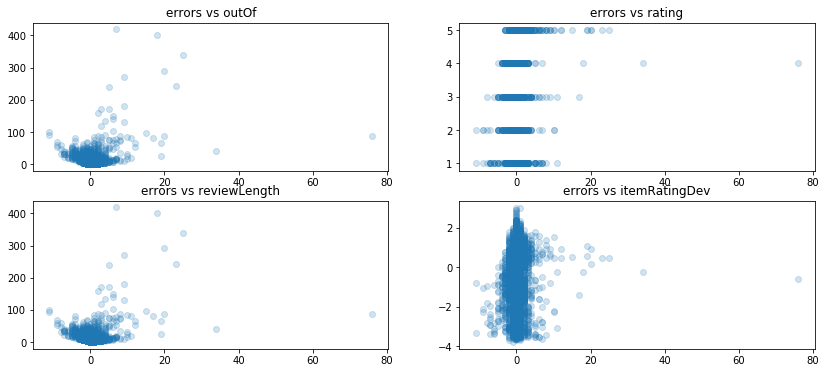

In [14]:
errors = nHelpful - df_test['nHelpful']
# check regression errors(residuals), it should be random(no pattern) if the model works well
plt.figure(figsize=(14,6))

plt.subplot(2,2,1)
plt.title('errors vs outOf')
plt.scatter(errors, df_test['outOf'], alpha=0.2)

plt.subplot(2,2,2)
plt.title('errors vs rating')
plt.scatter(errors, df_test['rating'], alpha=0.2)

plt.subplot(2,2,3)
plt.title('errors vs reviewLength')
plt.scatter(errors, df_test['outOf'], alpha=0.2)

plt.subplot(2,2,4)
plt.title('errors vs itemRatingDev')
plt.scatter(errors, df_test['itemRatingDev'], alpha=0.2)

plt.show()

C:\Users\wenyan\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


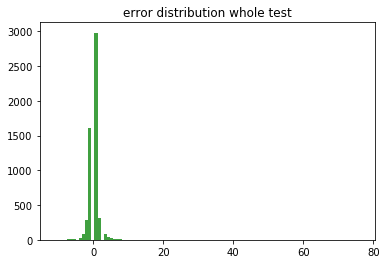

(36596, 41)


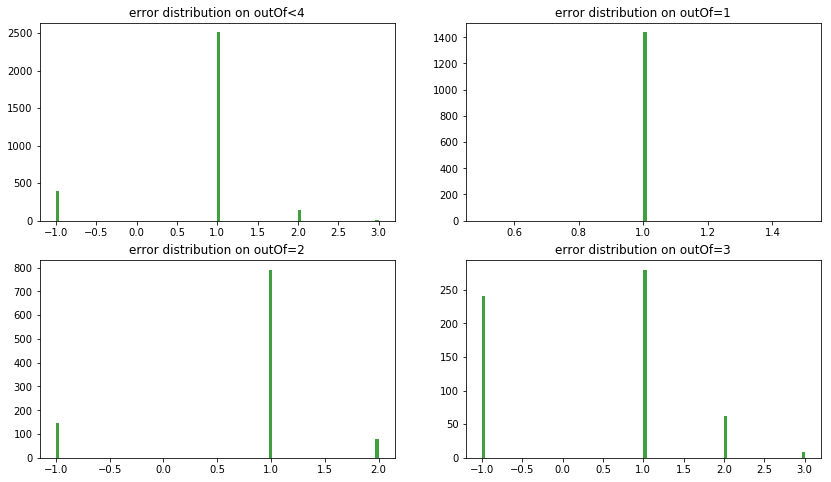

In [15]:
# check the errors on outOf<3, since that's majority from data distribution
df_test['error'] = errors

plt.title('error distribution whole test')
plt.hist(df_test[(df_test['error']!=0)]['error'], 100, histtype='bar', facecolor='green', alpha=0.75)
plt.show()

df1 = df_test[df_test['outOf']<4]
print(df_test[df_test['outOf']<4].shape)
plt.figure(figsize=(14,8))
plt.subplot(2,2,1)
plt.title('error distribution on outOf<4')
plt.hist(df1[(df1['error']!=0)]['error'], 100, histtype='bar', facecolor='green', alpha=0.75)
plt.subplot(2,2,2)
plt.title('error distribution on outOf=1')
plt.hist(df1[(df1['error']!=0)&(df1['outOf']==1)]['error'], 100, histtype='bar', facecolor='green', alpha=0.75)
plt.subplot(2,2,3)
plt.title('error distribution on outOf=2')
plt.hist(df1[(df1['error']!=0)&(df1['outOf']==2)]['error'], 100, histtype='bar', facecolor='green', alpha=0.75)
plt.subplot(2,2,4)
plt.title('error distribution on outOf=3')
plt.hist(df1[(df1['error']!=0)&(df1['outOf']==3)]['error'], 100, histtype='bar', facecolor='green', alpha=0.75)
plt.show()


### problem ###
From above, one single model doesn't work well on test with small outOf, as errors are all 1 for outOf=1 while ideally they should be evenly distributed on [-1, 1].


### multiple clusters ###
Since the distribution of data according to outOf is long-tailed shape, try spliting the whole data to multiple segments, train different model for each of them. For testing, same segments will be applied.
* outOf == 0: nHelpful =0
* outOf == 1: classification with decision tree, SVM
* outOf > 1: split to 2 or more groups with linear regression model for each

### outOf==1, classification
Tried different models: decision tree, SVM. 
But they didn't work well for me, I finally give up on this approach.

In [16]:
# for outOf=1, classification problem, nHelpful=[0,1]
df_valid = df[(df['outOf'] > 0) & (df['outOf'] < 2) \
              #& (df['nHelpful'] > 0) \
              & (df['reviewLength'] < 7500) \
              & (df['summaryLength'] < 150) \
              & (df['itemAvgOutOf'] < 20) \
              & (df['userAvgOutOf'] < 70) \
              & (df['userReviewCount'] < 75) \
              & (df['itemAvgReviewLengthRatio'] < 10) \
             ]
features0 = ['rating', 'itemRatingDev','itemReviewTimePast', 'reviewLength', \
           #'itemAvgOutOf',  'itemAvgReviewLengthRatio', \
           #'itemReviewCount', 'itemAvgRating', 'itemOutOfRatio1', 'userReviewCount']
            #'itemRatingDev', 'itemReviewTimePast' \
            ]
print('train valid size:{}'.format(df_valid.shape[0])) 
from sklearn.tree import DecisionTreeClassifier
best_criterion = ''
best_depth = 0
best_leaf_size = 0
best_mae = 100
for criterion in ['gini', 'entropy']:
  for d in list(range(5,10)):
    for leaf_size in [10,20,40,60]:
        X_train, X_val, y_train, y_val = train_test_split(df_valid[features0], df_valid[['helpfulRate','nHelpful']], test_size=0.4, random_state=5)
        clf = DecisionTreeClassifier(max_depth=d, criterion=criterion, min_samples_leaf=leaf_size)
        clf.fit(X_train, y_train['nHelpful'])
        y_pred = clf.predict(X_val)
        mae = mean_absolute_error(y_val['nHelpful'], y_pred)
        #print('Validation mae for criterion:{} min_samples_leaf:{} - {}'.format(criterion, leaf_size, mae))
        if mae < best_mae:
            best_criterion, best_depth, best_leaf_size, best_mae = criterion, d, leaf_size, mae
print("Will choose to use criterion: {}, depth:{} leaf_size: {}, best_mae:{}".format(best_criterion, best_depth, best_leaf_size, best_mae))
model0 = DecisionTreeClassifier(max_depth=best_depth, criterion=best_criterion, min_samples_leaf=best_leaf_size)
model0.fit(df_valid[features0], df_valid['nHelpful'])


train valid size:28509
Will choose to use criterion: gini, depth:5 leaf_size: 10, best_mae:0.2388635566467906


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=10,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

### outOf>1

### metrics ###
Loop trying different combinations of group splitting, feature set

In [13]:
def group_predict(models, thresh, df, features):
    groups = len(models)
    total_errors = 0
    nHelpfulAll =[]

    for g in range(groups):
        if g == 0:
            X = df[(df['outOf']<=thresh[g])]
        elif g == groups-1:
            X = df[(df['outOf']>thresh[g-1])]
        else:
            X = df[(df['outOf']>thresh[g-1]) & (df['outOf']<=thresh[g])]

        helpfulRate = np.clip(models[g].predict(X[features]), 0, 1)
        nHelpful = round(X['outOf'] * helpfulRate)
        df.loc[X.index,'nHelpful1'] = nHelpful
        nHelpfulAll.append(nHelpful)
        #total_errors += sum(abs(nHelpful - X['nHelpful']))
    return total_errors

In [48]:
# try different grouping threshold
# use below for training validation
df_valid = df_train[\
              (df_train['outOf'] > 0) \
               &(df_train['outOf'] < 500) \
              #& (df_train['nHelpful'] > 0) \
              & (df_train['reviewLength'] < 7500) \
              #& (df_train['itemAvgOutOf'] < 20) \
              #& (df_train['userAvgOutOf'] < 70) \
              #& (df_train['userReviewCount'] < 75) \
              #& (df_train['itemAvgReviewLengthRatio'] < 10) \
             ]
# use below for final model fitting with whole dataset
df_valid = df[\
              (df['outOf'] > 0) \
              &(df_train['outOf'] < 500) \
              #& (df_train['nHelpful'] > 0) \
              & (df['reviewLength'] < 7500) \
              #& (df_train['itemAvgOutOf'] < 20) \
              #& (df_train['userAvgOutOf'] < 70) \
              #& (df_train['userReviewCount'] < 75) \
              #& (df_train['itemAvgReviewLengthRatio'] < 10) \
             ]

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingRegressor

feature_sets = [
        #['rating','outOf','itemRatingDev',],
        #['rating','reviewLength','itemRatingDev','itemReviewTimePast'],
        #['rating','reviewLength','itemRatingDev',],
        #['rating','itemAvgReviewLengthRatio','itemRatingDev',],
        #['rating','outOf','itemRatingDev','itemOutOfRatio1'],
        ['rating','reviewLength', 'outOf','itemRatingDev','itemOutOfRatio1'],

        ['rating','reviewLength','itemRatingDev','outOf','itemReviewTimePast'],
        #['rating','itemAvgReviewLengthRatio','itemRatingDev','outOf'],
        #['rating','reviewLength','itemRatingDev','itemReviewTimePast'],
        #['rating','itemAvgReviewLengthRatio','itemRatingDev','outOf'],
        #['rating','reviewLength','itemRatingDev','itemReviewTimePast', 'outOf'],
]

best_overall_mae = 100
best_split = []
best_model_set = []
best_feature = []
for features in feature_sets:
  for thresh in [
            #[1],[2],[3],[5],[8],[10],[15],[30],
            #[5],
            #[1,10],[2,8],[2,9],[2,10],[2,15],[3,8],[3,10],[3,15],
            #[2,10],
            #[7, 10], [7,15], [7,30], [2,10],
            #[3,7,30],[2,7,30],[3,9,30],[2,8,25],[2,8,30], [3,8,25], [3,8,30]            
            [2,8,30],
            [2,10,30]
            #[2,7,15,30], [2,7,10,30],[2,7,12,30],[2,8,15,30],[2,8,10,30]
            #[2,8,25,90],[2,8,25,100],[2,10,30,100]

            ]:
    models = []
    groups = len(thresh) + 1
    sizes = []
    for g in range(groups):
        if g == 0:
            X = df_valid[(df_valid['outOf']<=thresh[g])]
        elif g == groups-1:
            X = df_valid[(df_valid['outOf']>thresh[g-1])]
        else:
            X = df_valid[(df_valid['outOf']>thresh[g-1]) & (df['outOf']<=thresh[g])]
        sizes.append(X.shape[0])
        X_train, X_val, y_train, y_val = train_test_split(X, X[['helpfulRate','nHelpful']], test_size=0.3, random_state=4)

        best_mae = 100
        best_param = ()
        best_model = 0
        #for n in ['linear']:
        #    model = LinearRegression(fit_intercept=True, normalize=True).fit(X_train[features], y_train['helpfulRate'])
        #for n in [100,110,120,130]:
        for n in [110,120,130,140]:
          for d in [3,4,5,6]:
            model = GradientBoostingRegressor(n_estimators=n, learning_rate=0.1,
             max_depth=d, random_state=0, loss='ls').fit(X_train[features], y_train['helpfulRate'])
            helpfulRate2 = np.clip(model.predict(X_val[features]), 0, 1)
            nHelpful2 = round(X_val['outOf'] * helpfulRate2)
            mae = mean_absolute_error(y_val['nHelpful'], nHelpful2)
            mse = mean_absolute_error(y_val['helpfulRate'], helpfulRate2)
            #print('group:{} model {} : mae on val data:{}'.format(g, (m,d), mae))

            if best_mae > mae: 
                best_mae = mae
                best_param = (n, d)
                best_model = model
        print('best param:', g, best_param)
        best_model = best_model.fit(X[features], X['helpfulRate'])
        models.append(best_model)

    total_errors = group_predict(models, thresh, df_test, features)
    mae = mean_absolute_error(df_test['nHelpful1'], df_test['nHelpful'])
    print('final mae for spliting at:{}, group size:{}, mae:{}'.format(thresh, sizes, mae))
    if mae < best_overall_mae:
        best_overall_mae = mae
        best_split = thresh
        best_model_set = models
        best_feature = features

print('best splitting: ', best_split)
print('best features: ', best_feature)

best param: 0 (140, 3)


C:\Users\wenyan\Anaconda3\lib\site-packages\ipykernel\__main__.py:67: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


best param: 1 (130, 6)
best param: 2 (120, 3)
best param: 3 (110, 3)


C:\Users\wenyan\Anaconda3\lib\site-packages\pandas\core\indexing.py:477: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


final mae for spliting at:[2, 8, 30], group size:[40573, 16374, 5098, 962], mae:0.156
best param: 0 (140, 3)
best param: 1 (140, 4)
best param: 2 (140, 3)
best param: 3 (110, 3)
final mae for spliting at:[2, 10, 30], group size:[40573, 17771, 3701, 962], mae:0.15975
best param: 0 (120, 3)
best param: 1 (140, 3)
best param: 2 (110, 3)
best param: 3 (110, 3)
final mae for spliting at:[2, 8, 30], group size:[40573, 16374, 5098, 962], mae:0.16345
best param: 0 (120, 3)
best param: 1 (140, 5)
best param: 2 (110, 3)
best param: 3 (110, 3)
final mae for spliting at:[2, 10, 30], group size:[40573, 17771, 3701, 962], mae:0.159
best splitting:  [2, 8, 30]
best features:  ['rating', 'reviewLength', 'outOf', 'itemRatingDev', 'itemOutOfRatio1']


In [49]:
test_df['nHelpful'] = group_predict(best_model_set, best_split, test_df, best_feature)

predictions = open("predictions_Helpful_group_linear23.txt", 'w')
i = 0
for l in open("pairs_Helpful.txt"):
  if l.startswith("userID"):
    #header
    predictions.write(l)
    continue
  user,item,outOf = l.strip().split('-')
  outOf = int(outOf)
  nHelpful = int(test_df.ix[i].nHelpful1)
  predictions.write(user + '-' + item + '-' + str(outOf) + ',' + str(nHelpful) + '\n')
  i += 1
predictions.close()